In [74]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif',
    rc={'font.size':12, 'mathtext.fontset': 'cm', 'axes.labelpad':0, 'axes.linewidth': 0.5})

# WM

### Plot histogram of percent errors across subjects, colored by z

In [75]:
z0 = pd.read_pickle(f"data/WM_z0.0.pkl").query("type=='model-WM'")
z01 = pd.read_pickle(f"data/WM_z0.1.pkl").query("type=='model-WM'")
z02 = pd.read_pickle(f"data/WM_z0.2.pkl").query("type=='model-WM'")
z04 = pd.read_pickle(f"data/WM_z0.4.pkl").query("type=='model-WM'")
z05 = pd.read_pickle(f"data/WM_z0.5.pkl").query("type=='model-WM'")
z07 = pd.read_pickle(f"data/WM_z0.7.pkl").query("type=='model-WM'")
z10 = pd.read_pickle(f"data/WM_z1.0.pkl").query("type=='model-WM'")
z15 = pd.read_pickle(f"data/WM_z1.5.pkl").query("type=='model-WM'")
combined = pd.concat([z0, z01, z02, z04, z05, z07, z10, z15], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'z', 'percent error']
for z in combined['z'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("z==@z & sid==@sid")
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing z={z} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        df = pd.DataFrame([['model-WM', sid, str(z), percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

### Find the z which minimizes error for each sid, and save the data from that model

In [76]:
dfs = []
dfs_reduced = []
columns_reduced = ['type', 'sid', 'z', 'percent error']
for sid in combined['sid'].unique():
    error_min = 1.0
    z_best = None
    for z in combined['z'].unique():
        subdata = combined.query("z==@z & sid==@sid")
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing z={z} sid={sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        if percent_error < error_min:
            error_min = percent_error
            z_best = z
    bestdata = combined.query("z==@z_best & sid==@sid")
    dfs.append(bestdata)
    dfs_reduced.append(pd.DataFrame([['model-WM', sid, 'best', error_min]], columns=columns_reduced))
fitted = pd.concat(dfs, ignore_index=True)
reduced_fitted = pd.concat(dfs_reduced, ignore_index=True)

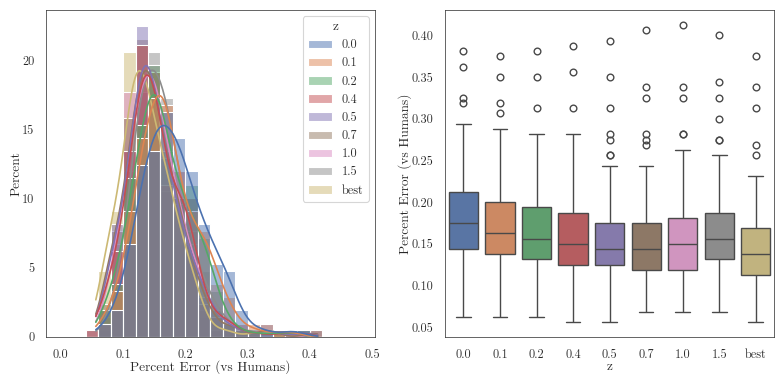

In [77]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
withbest = pd.concat([reduced, reduced_fitted], ignore_index=True)

sns.histplot(withbest, x='percent error', hue='z', ax=axes[0], stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(withbest, x='z', y='percent error', hue='z', ax=axes[1])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="z", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
fig.savefig("plots/wm_errors.png", dpi=600)